# 의료용 마스크 탐지 모델 구축 : 데이터 탐색 및 전처리

## Data Set Download

Link : [Face Mask Detection](https://www.kaggle.com/andrewmvd/face-mask-detection)

In [1]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.


In [2]:
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

Face Mask Detection.zip is done!


In [3]:
!unzip -q Face\ Mask\ Detection.zip

## Bounding Box 도식화

bounding box 시각화 코드를 테스트 하기 위한 패키지를 불러온다.  

matplotlib : 시각화  
glob : 파일 다루는 데 널리 사용됨  
BeautifulSoup : HTML과 XML 문서 파일을 parsing하는 패키지이며, web scraping에 유용  

In [4]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

In [5]:
# glob 패키지를 이용해 데이터셋 불러옴
# sorted함수를 사용해 img_list에 있는 파일의 Id 순서와 annot_list에 있는 파일의 id 순서가 같도록 함.

img_list = sorted(glob.glob('images/*'))
annot_list = sorted(glob.glob('annotations/*'))

In [6]:
print(len(img_list))
print(len(annot_list))

853
853


In [7]:
print(img_list[:10])
print(annot_list[:10])

['images/maksssksksss0.png', 'images/maksssksksss1.png', 'images/maksssksksss10.png', 'images/maksssksksss100.png', 'images/maksssksksss101.png', 'images/maksssksksss102.png', 'images/maksssksksss103.png', 'images/maksssksksss104.png', 'images/maksssksksss105.png', 'images/maksssksksss106.png']
['annotations/maksssksksss0.xml', 'annotations/maksssksksss1.xml', 'annotations/maksssksksss10.xml', 'annotations/maksssksksss100.xml', 'annotations/maksssksksss101.xml', 'annotations/maksssksksss102.xml', 'annotations/maksssksksss103.xml', 'annotations/maksssksksss104.xml', 'annotations/maksssksksss105.xml', 'annotations/maksssksksss106.xml']


### bounding box 시각화

In [19]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

In [20]:
# 마스크 착용 여부를 세 단계로 나눠서 0, 1, 2 값을 반환

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0


In [21]:
# generate_box와 generate_label을 각각 호출해 반환된 값을 딕셔너리에 저장해 반환하는 함수

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

In [22]:
def plot_image_from_output(img, annotation):
    
    img = img.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [15]:
# maksssksksss0.png 파일의 인덱스 값
test = img_list.index('images/maksssksksss111.png') 
print(test)

15


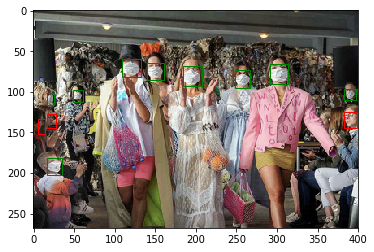

In [16]:
bbox = generate_target(annot_list[test])
plot_image(img_list[test], bbox)

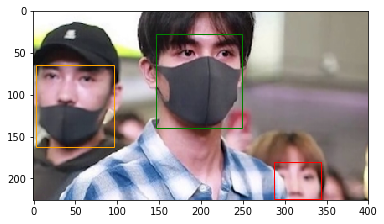

In [17]:
test = img_list.index('images/maksssksksss307.png') 
bbox = generate_target(annot_list[test])
plot_image(img_list[test], bbox)

## 데이터 전처리 
## Augmentation

In [18]:
!pip install --upgrade albumentations

Looking in indexes: http://ftp.daumkakao.com/pypi/simple
     |████████████████████████████████| 72 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 38.2 MB 23.7 MB/s eta 0:00:01
     |████████████████████████████████| 948 kB 101.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 100.4 MB/s eta 0:00:01
You should consider upgrading via the '/home/ubuntu/anaconda3/envs/pytorch_p36/bin/python -m pip install --upgrade pip' command.


### Torchvision Transforms

torchvision.transforms을 실습하기 위해 TorchvisionDataset 클래스를 먼저 정의. TorchvisionDataset 클래스는 ______getitem___ 메소드를 통해 image를 불러온 다음 데이터 augmentation을 진행. transform 파라미터에 저장돼있는 augmentation 규칙에 따라 augmentation이 이뤄진다. 시간 측정을 위해 time 함수를 사용해 시간 측정 후, 최종적으로 image, label, total_time을 반환.

In [23]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

In [24]:
class TorchvisionMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        
        target = generate_target(label_path)
        
        start_t = time.time()
        if self.transform:
            img = self.transform(img)

        total_time = (time.time() - start_t)

        return img, target, total_time

torchvision.transforms에서 제공하는 함수를 활용해 이미지 augmentation 실습을 진행. 이미지를 (300, 300) 크기로 만든 후, 224 크기로 자른다.   
이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 무작위로 바꾸고 이미지 좌우 반전을 적용한 후 tensor로 변환

In [25]:
torchvision_transform = transforms.Compose([
    transforms.Resize((300, 300)),  # 이미지 크기 조정
    transforms.RandomCrop(224),  # 이미지 자르기
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 밝기, 대비, 채도, 색조 임의로 변경
    transforms.RandomHorizontalFlip(p = 1),  # 정의한 p 확률로 좌우반전을 실시
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionMaskDataset(
    path = 'images/',
    transform = torchvision_transform
)

transforms 적용 전


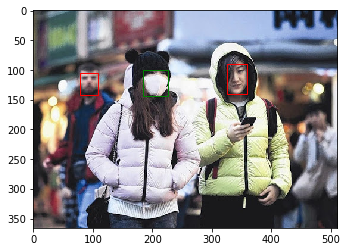

transforms 적용 후


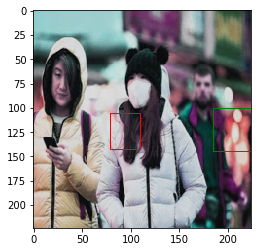

In [26]:
only_totensor = transforms.Compose([transforms.ToTensor()])

torchvision_dataset_no_transform = TorchvisionMaskDataset(
    path = 'images/',
    transform = only_totensor
)

img, annot, transform_time = torchvision_dataset_no_transform[0]
print('transforms 적용 전')
plot_image_from_output(img, annot) 

img, annot, transform_time = torchvision_dataset[0]

print('transforms 적용 후')
plot_image_from_output(img, annot)

이미지 자체적인 변화는 이뤄졌지만 Bounding box는 변화된 이미지에서 위치가 어긋난다. torchvision.transform에서 제공하는 augmentation은 이미지 값에 대한 augmentation만 진행이 되며, bounding box는 같이 변환되지 않는다.  

이미지 분류 문제에서는 이미지가 변해도 라벨값이 고정이지만, 객체 검출 문제에서는 이미지가 변함에 따라 라벨 값 또한 함께 변해야 한다.

Albumentations에서 제공하는 Compose 함수에 있는 bbox_params 파라미터를 활용하면 바운딩 박스 augmentation이 가능.

In [27]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}
        
            
        return image, target

다음으로는 albumentations.Compose 함수를 활용해 변환을 정의. 가장 먼저 좌우반전을 실시, 그 이후에 -90도에서 90도 사이의 회전을 진행.   
바운딩 박스도 함께 변환을 진행해주기 위해 bbox_params 파라미터에 albumentations.BboxParams 객체를 입력.   
Face Mask Detection 데이터셋은 바운딩 박스 표기법이 xmin, ymin, xmax, ymax으로 돼 있고, 이것은 pascal_voc 표기법과 같다. 그러므로 format 파라미터에 pascal_voc을 입력. 또한 transform 진행 시 객체별 클래스 값은 labels 파라미터에 저장해두기 위해 label_field에 labels를 입력

In [28]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensor()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

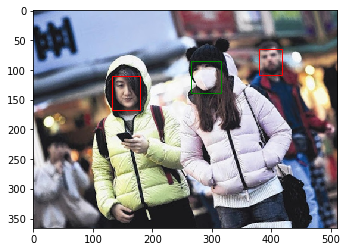

In [29]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

torchvision_dataset에서 이미지 변환에 소요된 시간을 계산하고 그것을 100번 반복한 시간을 아래 코드를 활용해 측정

In [30]:
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time: {} ms".format(total_time*10))

torchvision time: 17.477426528930664 ms


### Albumentations

AlbumentationDataset은 TorchVisionDataset과 비슷한 구조를 가지고 있다.  
cv2 모듈을 사용하여 이미지를 읽고 RGB로 바꾼 후 이미지 변환을 실시해 결과값을 반환

In [31]:
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']
        
            
        return image, target, total_time

In [33]:
# orchvision_transform과 속도 비교
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1), 
    albumentations.HorizontalFlip(p=1), 
    albumentations.pytorch.transforms.ToTensor()
])

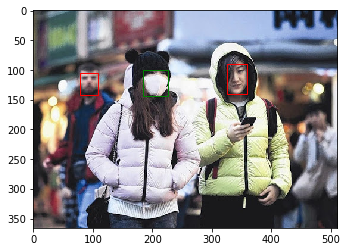

In [34]:
# 변경 전

img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(img, annot)

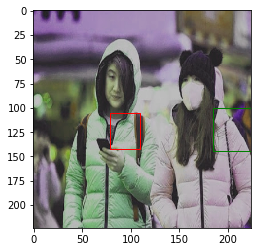

In [35]:
# 변경 후

albumentation_dataset = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[0]
plot_image_from_output(img, annot)

In [36]:
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("Albumentations time: {} ms".format(total_time*10))

Albumentations time: 8.458001613616943 ms


### 확률 기반 Augmentation 조합

OneOf 함수는 list 안에 있는 augmentation 기능 들을 주어진 확률 값에 기반하여 가져온다. list 값 자체의 확률 값과 더불어 해당 함수의 확률 값을 함께 고려하여 실행 여부를 결정. 아래의 OneOf 함수는 각각 선택될 확률이 1. 각각의 함수 내부에 있는 3개의 albumentations 기능들 또한 각각 확률 값이 1로 부여 됐으므로, 실질적으로 1/3의 확률로 3개의 기능 중 하나가 선택되어 실행된다. 확률값을 조정해가며 다양한 augmentation이 가능

In [37]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensor()
])

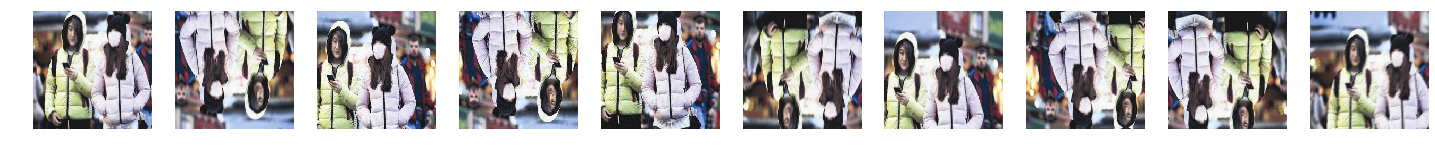

In [38]:
albumentation_dataset_oneof = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis('off')

### Bounding Box Augmentation

객체 탐지 모델 구축에 사용되는 이미지에 대한 augmentation 진행 시, 바운딩 박스 변환도 함께 진행해야 한다.  
Albumentations에서 제공하는 Compose 함수에 있는 bbox_params 파라미터를 활용하면 바운딩 박스 augmentation이 가능.

In [39]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}
        
            
        return image, target

다음으로는 albumentations.Compose 함수를 활용해 변환을 정의.   
가장 먼저 좌우반전, 그 이후에 -90도에서 90도 사이의 회전을 진행.   
바운딩 박스도 함께 변환을 진행해주기 위해 bbox_params 파라미터에 albumentations.BboxParams 객체를 입력. Face Mask Detection 데이터셋은 바운딩 박스 표기법이 xmin, ymin, xmax, ymax으로 돼 있고, 이것은 pascal_voc 표기법과 같다. 그러므로 format 파라미터에 pascal_voc을 입력. 또한 transform 진행 시 객체별 클래스 값은 labels 파라미터에 저장해두기 위해 label_field에 labels를 입력

In [42]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensor()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

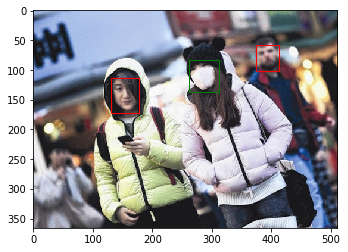

In [43]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

## 데이터 분리

In [44]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

853
853


In [45]:
# 일반적으로는 학습 데이터와 테스트 데이터의 비율은 7:3. But 데이터 수가 적으므로 8:2로 나눈다.
# 데이터를 담을 폴더만들기

!mkdir test_images
!mkdir test_annotations

In [46]:
import random
random.seed(1234)
idx = random.sample(range(853), 170)
print(len(idx))
print(idx[:10])

170
[796, 451, 119, 7, 92, 826, 596, 35, 687, 709]


In [47]:
import numpy as np
import shutil
# shutil 패키지를 활용해 170개의 이미지와 170개의 좌표 파일들을 각각 test_image 폴더와 test_annotations 폴더로 옮김

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

In [48]:
# 폴더별 파일 개수

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

683
683
170
170


객체 탐지 문제에서는 각 클래스별로 몇 개의 객체가 데이터셋 내부에 존재하는지 확인하는 작업이 필요.

In [49]:
from tqdm import tqdm
import pandas as pd
from collections import Counter

# 데이터셋에 있는 모든 바운딩 박스의 라벨 값을 total_labels에 저장 후 Counter 클래스를 활용해 라벨별 개수를 세어 반환하는 함수
def get_num_objects_for_each_class(dataset):

    total_labels = []

    for img, annot in tqdm(dataset, position = 0, leave = True):
        total_labels += [int(i) for i in annot['labels']]

    return Counter(total_labels)


train_data =  BboxAugmentationDataset(
    path = 'images/'
)

test_data =  BboxAugmentationDataset(
    path = 'test_images/'
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print('\n train 데이터에 있는 객체', train_objects)
print('\n test 데이터에 있는 객체', test_objects)

100%|██████████| 170/170 [00:02<00:00, 56.95it/s]


 train 데이터에 있는 객체 Counter({1: 2691, 0: 532, 2: 97})

 test 데이터에 있는 객체 Counter({1: 541, 0: 185, 2: 26})


학습용 데이터에는 532개의 0번 클래스, 2,691개의 1번 클래스, 97개의 2번 클래스가 위치해 있으며 시험용 데이터에는 185개의 0번 클래스, 541개의 1번 클래스, 26개의 2번 클래스가 위치해 있다.  
데이터셋별로 0,1,2 비율이 유사 -> 적절히 데이터가 나뉨